In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skimage.segmentation import slic

from src.utils.video_utils import get_video, get_frame_from_video
from src.utils.ground_utils import get_mask as get_ground_mask
from src.utils.ground_utils import get_model_from as get_ground_model_from

DATA_PATH = '../data/'
GENERATED_PATH = '../generated/'
LDR_PATH = f'{DATA_PATH}ldr/'
GENERATED_MASK_PATH = f'{GENERATED_PATH}sky_cloud_segmentation/scene_masks/'

N_SEGMENTS = 1000
COMPACTNESS = 3
SIGMA = 3

In [3]:
ground_model_type = 'deeplabv3mobilenetv3large'
ground_model_save_path = f"{DATA_PATH}sky_ground_segmentation/models/{ground_model_type}_ranger_pretrained.pth"
ground_model = get_ground_model_from(model_save_path=ground_model_save_path, model_type=ground_model_type)

✅ Loaded pretrained model deeplabv3mobilenetv3large with 11,024,445 learnable parameters.
✅ Loaded model from ../data/sky_ground_segmentation/models/deeplabv3mobilenetv3large_ranger_pretrained.pth


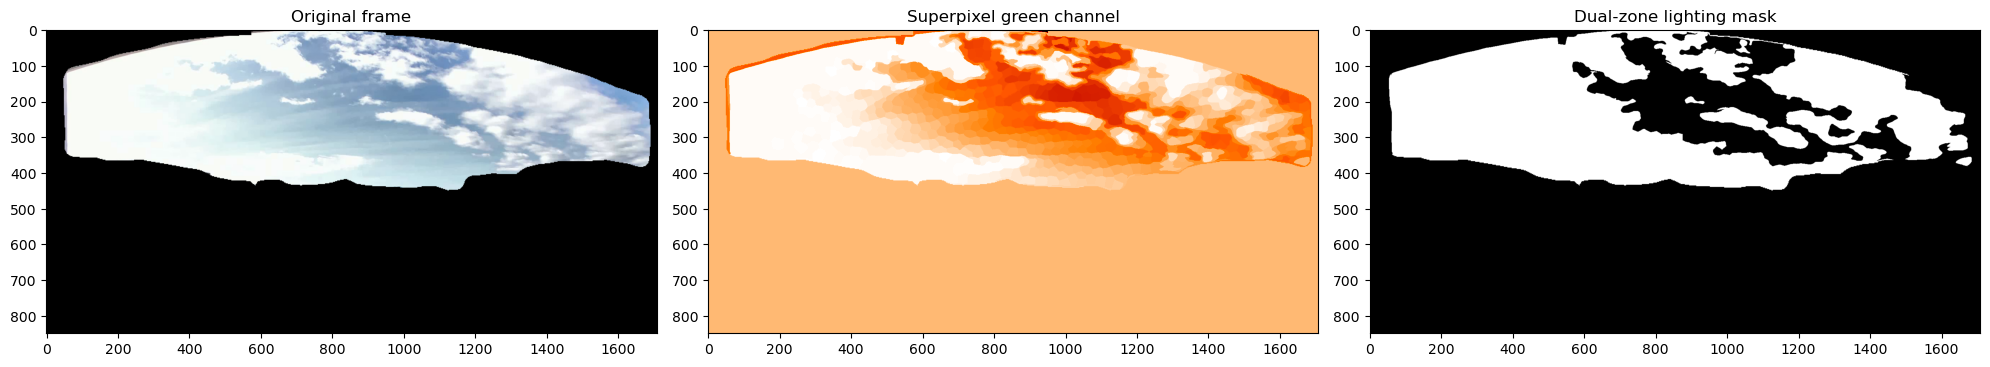

In [23]:
# Get scene frames
scene_path = f'{LDR_PATH}processed/P1Scene05.mp4'
scene_video = get_video(scene_path)
scene_frame, _ = get_frame_from_video(scene_video, 3, split=False, masked=True, reframed=True)
rgb_frame = cv2.cvtColor(scene_frame, cv2.COLOR_BGR2RGB)

# Get ground mask
scene_ground_mask = get_ground_mask(rgb_frame / 255, ground_model)
rgb_frame = rgb_frame * scene_ground_mask[:, :, np.newaxis]

# Get l channel
l = rgb_frame[:, :, 1]

# Apply superpixel segmentation
superpixels = slic(
    rgb_frame,
    n_segments=N_SEGMENTS,
    compactness=COMPACTNESS,
    sigma=SIGMA,
    mask=scene_ground_mask,
)

# Replace ground pixels by mean of sky
masked_l_channel = l.copy()
masked_l_channel[~scene_ground_mask] = np.mean(l[scene_ground_mask])

# Rebuild image based on superpixels
sp_masked_l_channel = masked_l_channel.copy()
for superpixel_value in np.unique(superpixels):
    mask = superpixels == superpixel_value
    sp_masked_l_channel[mask] = np.median(masked_l_channel[mask])

# Apply Otsu thresholding and apply mask
_, sp_lighting_mask = cv2.threshold(
    sp_masked_l_channel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)
sp_lighting_mask = sp_lighting_mask.astype(bool)
sp_lighting_mask = sp_lighting_mask * scene_ground_mask

# Plot
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(rgb_frame)
ax[0].set_title('Original frame')
ax[1].imshow(sp_masked_l_channel, cmap='gist_heat')
ax[1].set_title('Superpixel green channel')
ax[2].imshow(sp_lighting_mask, cmap='gray')
ax[2].set_title('Dual-zone lighting mask')
plt.tight_layout()
plt.show()